In [1]:
import requests
import pandas as pd
import io

In [2]:
def crawler(data_time):
    url =  'https://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + data_time + '&type=ALLBUT0999'
    page = requests.get(url).text
    use_text = page.splitlines()
    for i, text in enumerate(use_text):
        if text == '"證券代號","證券名稱","成交股數","成交筆數","成交金額","開盤價","最高價","最低價","收盤價","漲跌(+/-)","漲跌價差","最後揭示買價","最後揭示買量","最後揭示賣價","最後揭示賣量","本益比",':
            initial_point = i
            break
    test_df = pd.read_csv(io.StringIO((''.join([text[:-1] + '\n' for text in use_text[initial_point:]]))))
    test_df['證券代號'] = test_df['證券代號'].apply(lambda x:x.replace('"', ''))
    test_df['證券代號'] = test_df['證券代號'].apply(lambda x:x.replace('=', ''))
    return test_df

In [3]:
import datetime
import time

def trans_date(date_time):
    return str(date_time).split(' ')[0].replace('-', '')

def parse_n_days(start_date, n):
    df_dict = {}
    now_date = start_date
    for i in range(n):
        time.sleep(3)
        try:
            df = crawler(trans_date(now_date))
            print('Successful!!' + ' ' + trans_date(now_date))
            df_dict.update({trans_date(now_date):df})
        except:
            print('Fails at' + ' ' + trans_date(now_date))
        now_date = now_date - datetime.timedelta(days=1)
    return df_dict

In [ ]:
result_dict = parse_n_days(datetime.datetime.now(), 600)

In [ ]:
for key in result_dict.keys():
    result_dict[key].to_csv(str(key) + '.csv')

### Build a sqlite database, manipulate csv files

In [ ]:
import pandas as pd
import sqlite3
import glob

### Read all csv files
- import glob module
- Analyzing Data from Multiple Files

In [ ]:
All_csv_file = glob.glob('*.csv')

In [ ]:
df = pd.read_csv(All_csv_file[0])

In [ ]:
df.iloc[:,1:].head()  # read from 1st column

### Create a database by using sqlite3 module

In [ ]:
dbname = 'TWStock.db'

In [ ]:
db = sqlite3.connect(dbname)

In [ ]:
%%time
for file_name in All_csv_file:
    pd.read_csv(file_name).iloc[:,1:].to_sql(file_name.replace('.csv', ''), db, if_exists='replace')

CPU times: total: 9.17 s
Wall time: 26.5 s


### Read Database Table

In [ ]:
dates_list = [file_name.replace('.csv', '') for file_name in All_csv_file]

In [ ]:
%%time
total_df = pd.DataFrame()
for date in dates_list:
    df = pd.read_sql(con=db, sql='SELECT * FROM "' + date + '"')
    df['Date'] = date
    total_df = total_df.append(df)

In [ ]:
total_df.shape

(457457, 18)

In [ ]:
dbname_2 = 'TWStock_2'
db2 = sqlite3.connect(dbname_2)    # create a database connection

In [ ]:
%%time
total_dict = dict(tuple(total_df.groupby('證券代號')))

CPU times: total: 875 ms
Wall time: 875 ms


In [ ]:
for key in total_dict.keys():
    df = total_dict[key].iloc[:,2:]
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by=['Date'])
    df.to_sql(key, db2, if_exists='replace')

In [ ]:
pd.read_sql(con=db2, sql='SELECT * FROM "2330"').tail()

,index,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,漲跌(+/-),漲跌價差,最後揭示買價,最後揭示買量,最後揭示賣價,最後揭示賣量,本益比,Date
395,448,台積電,"24,991,291","26,792","12,569,771,761",506.00,508.00,500.00,504.00,-,5.0,503.00,6,504.00,315,19.81,2022-08-01 00:00:00
396,448,台積電,"42,669,591","63,879","20,973,293,337",494.00,496.00,488.50,492.00,-,12.0,491.50,44,492.00,350,19.34,2022-08-02 00:00:00
397,448,台積電,"29,838,832","25,570","14,823,224,632",494.00,501.00,493.00,501.00,+,9.0,500.00,9,501.00,581,19.69,2022-08-03 00:00:00
398,448,台積電,"26,589,086","27,173","13,279,624,282",499.00,503.00,495.00,500.00,-,1.0,499.50,592,500.00,4,19.65,2022-08-04 00:00:00
399,448,台積電,"35,052,642","49,928","17,966,410,242",509.00,516.00,507.00,516.00,+,16.0,515.00,732,516.00,478,20.28,2022-08-05 00:00:00


### Stock Close Price

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
db = sqlite3.connect('TWStock_2')
stock_dict = {}
stock_dict.update({'tsmc':pd.read_sql(con=db, sql='SELECT * FROM "2330"')})
stock_dict.update({'mtk':pd.read_sql(con=db, sql='SELECT * FROM "2454"')})
stock_dict.update({'umc':pd.read_sql(con=db, sql='SELECT * FROM "2303"')})
stock_dict.update({'rtk':pd.read_sql(con=db, sql='SELECT * FROM "2379"')})
stock_dict.update({'nova':pd.read_sql(con=db, sql='SELECT * FROM "3034"')})
stock_dict.update({'honhai':pd.read_sql(con=db, sql='SELECT * FROM "2317"')})
stock_dict.update({'mega':pd.read_sql(con=db, sql='SELECT * FROM "2886"')})
stock_dict.update({'esun':pd.read_sql(con=db, sql='SELECT * FROM "2884"')})
stock_dict.update({'cathay':pd.read_sql(con=db, sql='SELECT * FROM "2882"')})
stock_dict.update({'fubon':pd.read_sql(con=db, sql='SELECT * FROM "2881"')})
stock_dict.update({'formosa':pd.read_sql(con=db, sql='SELECT * FROM "1301"')})
stock_dict.update({'evergreen':pd.read_sql(con=db, sql='SELECT * FROM "2603"')})

In [ ]:
stock_dict['tsmc'].head()

,index,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,漲跌(+/-),漲跌價差,最後揭示買價,最後揭示買量,最後揭示賣價,最後揭示賣量,本益比,Date
0,423,台積電,"43,059,899","43,967","21,780,400,998",507.00,510.00,504.00,504.00,-,4.0,504.00,"1,130",505.00,169,26.61,2020-12-15 00:00:00
1,423,台積電,"53,661,282","30,574","27,504,184,031",509.00,515.00,507.00,512.00,+,8.0,511.00,506,512.00,677,27.03,2020-12-16 00:00:00
2,423,台積電,"39,285,785","34,785","20,052,530,030",515.00,515.00,508.00,508.00,X,0.0,508.00,"1,155",509.00,4,26.82,2020-12-17 00:00:00
3,423,台積電,"40,625,502","20,638","20,690,792,789",508.00,512.00,507.00,510.00,+,2.0,509.00,278,510.00,541,26.93,2020-12-18 00:00:00
4,423,台積電,"35,153,138","21,765","18,033,402,498",512.00,517.00,508.00,516.00,+,6.0,515.00,72,516.00,241,27.24,2020-12-21 00:00:00


In [ ]:
for key in stock_dict.keys():
    df = stock_dict[key]
    df.index = df['Date']
    df.index = pd.to_datetime(df.index)
    df = df[['證券名稱', '收盤價']]
    df['收盤價'] = pd.to_numeric(df['收盤價'].apply(lambda x:x.replace(',', '')), errors='coerce')
    df.columns = ['stock_code', 'close']
    stock_dict[key] = df

In [ ]:
stock_dict['tsmc']

,stock_code,close
Date,,
2020-12-15,台積電,504.0
2020-12-16,台積電,512.0
2020-12-17,台積電,508.0
2020-12-18,台積電,510.0
2020-12-21,台積電,516.0
...,...,...
2022-08-01,台積電,504.0
2022-08-02,台積電,492.0
2022-08-03,台積電,501.0


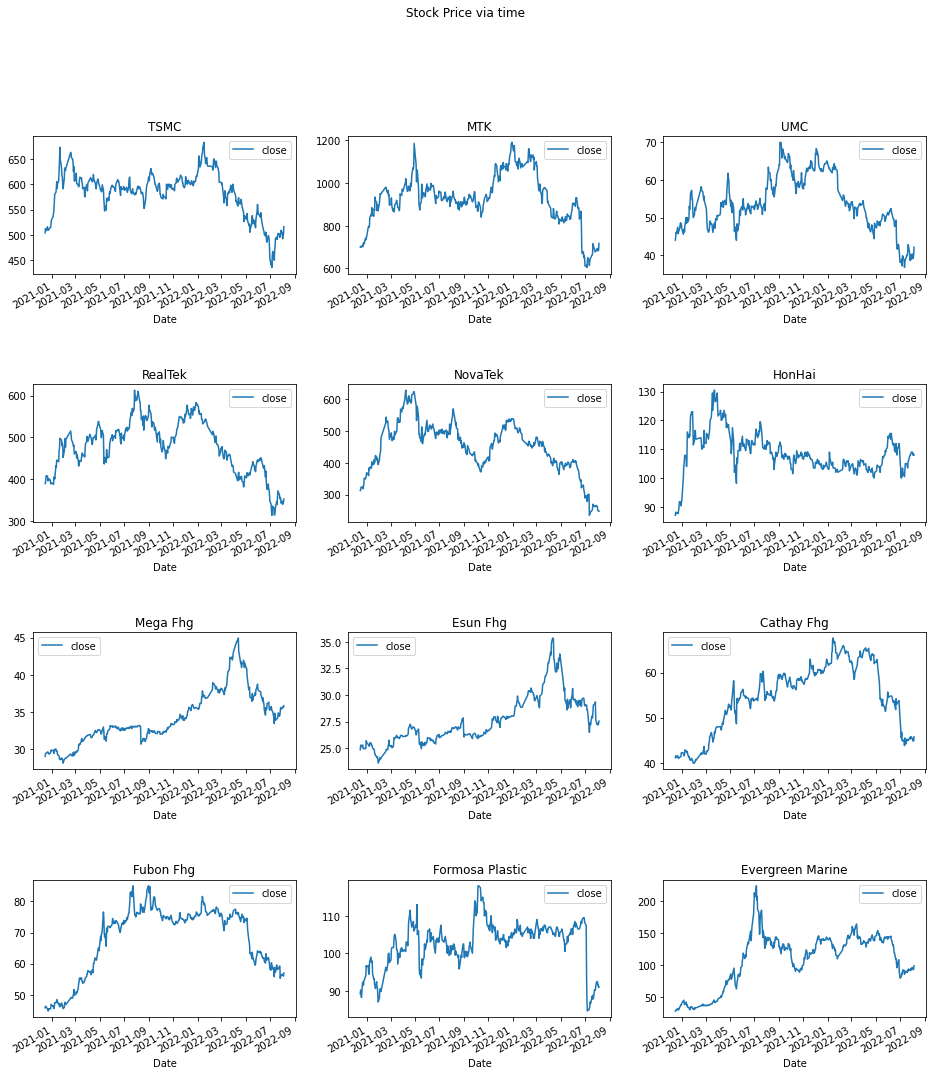

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(16, 18))
plt.subplots_adjust(hspace=0.8)
stock_dict['tsmc']['2020-12-15':].plot(ax=ax[0, 0])
ax[0, 0].set_title('TSMC')
stock_dict['mtk']['2020-12-15':].plot(ax=ax[0, 1])
ax[0, 1].set_title('MTK')
stock_dict['umc']['2020-12-15':].plot(ax=ax[0, 2])
ax[0, 2].set_title('UMC')
stock_dict['rtk']['2020-12-15':].plot(ax=ax[1, 0])
ax[1, 0].set_title('RealTek')
stock_dict['nova']['2020-12-15':].plot(ax=ax[1, 1])
ax[1, 1].set_title('NovaTek')
stock_dict['honhai']['2020-12-15':].plot(ax=ax[1, 2])
ax[1, 2].set_title('HonHai')
stock_dict['mega']['2020-12-15':].plot(ax=ax[2, 0])
ax[2, 0].set_title('Mega Fhg')
stock_dict['esun']['2020-12-15':].plot(ax=ax[2, 1])
ax[2, 1].set_title('Esun Fhg')
stock_dict['cathay']['2020-12-15':].plot(ax=ax[2, 2])
ax[2, 2].set_title('Cathay Fhg')
stock_dict['fubon']['2020-12-15':].plot(ax=ax[3, 0])
ax[3, 0].set_title('Fubon Fhg')
stock_dict['formosa']['2020-12-15':].plot(ax=ax[3, 1])
ax[3, 1].set_title('Formosa Plastic')
stock_dict['evergreen']['2020-12-15':].plot(ax=ax[3, 2])
ax[3, 2].set_title('Evergreen Marine')
fig.suptitle('Stock Price via time')
plt.show()
